# Basic Gaussian process regression (GPR)
In this notebook, we will go over the basics of Gaussian process regression and get familiar with the [GPSat Model API](../GPSat.models.rst) to get/set parameters, train our model and make predictions on new data points.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from GPSat.models.sklearn_models import sklearnGPRModel

2023-08-02 18:06:25.326820: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Consider data generated from a simple cosine function

\begin{align}
\tag{1}
y = \cos(X) + \epsilon,
\end{align}

where $X = (x_1, \ldots, x_N)$ is a set of randomly generated points within the interval $[-L, L]$, and $\epsilon$ is a measurement error, which we take to be an i.i.d. zero-mean Gaussian noise with standard deviation $0.05$.

Our goal is to use a Gaussian process model to filter out the noise $\epsilon$ and recover the function $f(x) = \cos(x)$ from the training data $(X, y)$.

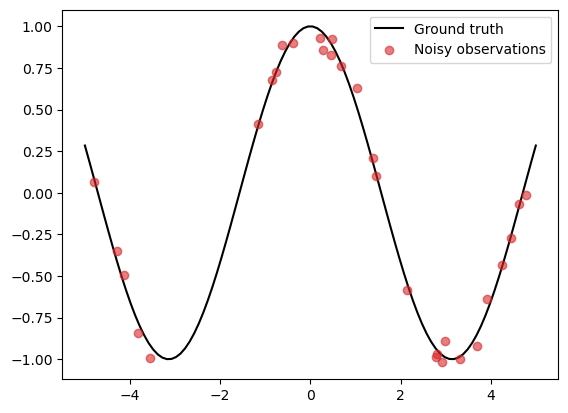

In [2]:
# Set random seed
np.random.seed(0)

# Generate data
N = 30
L = 5
noise_std = 0.05

X_grid = np.linspace(-L, L, 100)
X = np.random.uniform(-L, L, (N,))
f = lambda x: np.cos(x)
epsilon = noise_std * np.random.randn(N)

y = f(X) + epsilon
f_truth = f(X_grid) # Ground truth

# Plot
plt.plot(X_grid, f_truth, 'k', zorder=1, label='Ground truth')
plt.scatter(X, y, color='C3', alpha=0.6, zorder=2, label='Noisy observations')
plt.legend()

## Gaussian processes

Intuitively, a zero-mean Gaussian process (GP) can be understood as a Gaussian distribution on an *arbitrary collection of inputs*.

More specifically, it is a random function $f : \mathbb{R} \rightarrow \mathbb{R}$ such that for an arbitrary collection of inputs $X = (x_1, \ldots, x_N)$, the random variable $f(X)$ is a multivariate Gaussian

\begin{align*}
f(X) \sim \mathcal{N}(0, K_{XX}),
\end{align*}

for some $N \times N$ covariance matrix $K_{XX}$. Importantly, this covariance matrix can be computed using a **kernel function**  $k : \mathbb{R} \times \mathbb{R} \rightarrow \mathbb{R}$ as

\begin{align*}
[K_{XX}]_{ij} = k(x_i, x_j), \quad \forall i,j = 1, \ldots, N,
\end{align*}

and this completely characterises the zero-mean GP. i.e. the properties of a GP are completely determined by the kernel!

Below, we set up a GP with the so-called radial basis function (RBF) kernel, given as

\begin{align*}
\tag{RBF}
k_{\text{RBF}}(x, x') = \sigma^2 \exp\left(-\frac{|x-x'|^2}{2\ell^2}\right),
\end{align*}

using ``sklearnGPRModel``, a GPSat GP regression model based on the ``scikit-learn`` GPR module.

In [3]:
gpr = sklearnGPRModel(coords=X, obs=y, kernel='RBF', verbose=False)

'__init__': 0.040 seconds


In the expression for the kernel (RBF) above, we see that it is controlled by two parameters $\sigma^2$ and $\ell$, which are referred to as the *kernel variance* and the *lengthscale* hyperparameters respectively (in machine learning lingo, we refer to parameters that define the models as *hyperparameters*).

Every ``GPSat`` model comes equipped with a getter/setter method for all (hyper)-parameters in the model. A list of all parameters is stored in the ``param_names`` property.

In [4]:
print(gpr.param_names)

['lengthscales', 'kernel_variance', 'likelihood_variance']


We can retrieve their values using the ``get_*()`` method, where ``*`` is to be substituted with the parameter name.

In [5]:
ls = gpr.get_lengthscales()
kv = gpr.get_kernel_variance()

print(f"Lengthscale: {ls}, Kernel variance: {kv}")

Lengthscale: [1.], Kernel variance: 1.0


Suppose we want to set the kernel variance to 1.5. We can achieve this using the ``set_*()`` method.

In [6]:
gpr.set_kernel_variance(1.5)
kv = gpr.get_kernel_variance()
print(f"New kernel variance: {kv:.1f}")

New kernel variance: 1.5


## The likelihood
In ``param_names`` above, we also saw a parameter ``likelihood_variance``. This is not a hyperparameter of the GP kernel, but is instead a parameter of the so-called *likelihood*.

In general, the likelihood describes the probability of an observation $y$ given the ground truth field $f(X)$, i.e., the conditional distribution $p(y | f(X))$. In our case, since the observations are assumed to only differ from the ground truth by some measurement error, the likelihood is understood as modelling precisely this measurement error.

From (1), we see that the likelihood is given by

\begin{align*}
p(y | f(X)) \sim \mathcal{N}(f(X), \alpha^2 I),
\end{align*}

with $\alpha = 0.05$ and $f(x) = \cos(x)$. Here, the parameter $\alpha^2$ is referred to as the *likelihood variance*.

We can get the default value for the likelihood variance using the ``get_*`` method:

In [7]:
print(f"Likelihood variance: {gpr.get_likelihood_variance()}")

Likelihood variance: 1.0


and set the correct value by using the ``set_*`` method.

In [8]:
alpha = 0.05
gpr.set_likelihood_variance(alpha**2)
print(f"New likelihood variance: {gpr.get_likelihood_variance():.4f}")

New likelihood variance: 0.0025


Alternatively, we could have also initialised the GPR model by specifying the ``likelihood_variance`` and ``kernel_variance`` arguments with their respective values.

In [9]:
# This initialises a GP model with the desired values
gpr = sklearnGPRModel(coords=X, obs=y, kernel='RBF', likelihood_variance=alpha**2, kernel_variance=1.5, verbose=False)

ls = gpr.get_lengthscales()
kv = gpr.get_kernel_variance()
lv = gpr.get_likelihood_variance()

print(f"Lengthscale: {ls},  Kernel variance: {kv:.1f},  Likelihood variance: {lv:.4f}")

'__init__': 0.048 seconds
Lengthscale: [1.],  Kernel variance: 1.5,  Likelihood variance: 0.0025


## Prediction
From just these information, we can now infer what our ground truth function $f$ should be, given the data pair $(X, y)$.

Mathematically this is achieved by the simple, yet powerful **Bayes' rule** to update our belief on the function $f$ given our data $(X, y)$. Informally, this reads:

\begin{align}
\tag{2}
\underbrace{p(f \,|\, X, y)}_{\text{posterior}} \propto \underbrace{p(y \,|\, f(X))}_{\text{likelihood}} \,\, \underbrace{p(f)}_{\text{prior}}.
\end{align}

In GP regression, one can understand the GP as modelling a prior distribution on the function $f$. Thus, the term $p(f)$ corresponds to our GP model. The posterior distribution $p(f | X, y)$ thus gives our prediction of the field $f$ given the data.

In ``GPSat`` models, this is computed using the ``predict()`` method. This takes as inputs a set of $N_*$ prediction points, which must be an array of size $(N_*, D)$, where $D$ is the input dimension (in our case, just 1).

'predict': 0.010 seconds


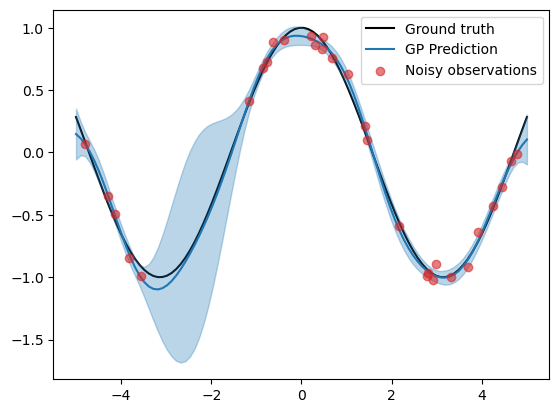

In [10]:
# Make predictions on a uniform grid
pred_dict = gpr.predict(X_grid.reshape(-1, 1))

# Extract the mean and variance from the results dictionary
f_mean = pred_dict['f*']
f_var = pred_dict['f*_var']
f_std = np.sqrt(f_var)

# Plot results
plt.plot(X_grid, f_truth, 'k', zorder=0, label='Ground truth')
plt.plot(X_grid, f_mean, color='C0', zorder=1, label='GP Prediction')
plt.fill_between(X_grid, f_mean-1.96*f_std, f_mean+1.96*f_std, color='C0', alpha=0.3)
plt.scatter(X, y, color='C3', alpha=0.6, zorder=2, label='Noisy observations')
plt.legend()


In the plot above, we have plotted the prediction in blue, where the shaded region indicates a 90% credible interval, where we believe the ground truth lies.

To assess the quality of this prediction, we can look at two metrics:

(1) the mean squared error $\frac{1}{N_*} \sum_{n=1}^{N^*} (f_{truth}(x_n') - f_{mean}(x_n'))^2$ between the predictive mean and the ground truth, and

(2) the mean log-likelihood $\frac{1}{N_*} \sum_{n=1}^{N^*} \log \mathcal{N}(f_{truth}(x_n') \,|\, f_{mean}(x_n'), f_{std}(x_n')^2)$ of the ground truth given the predictive mean and standard deviation.

The former only assess the quality of the mean, however the latter also assess the quality of the predictive uncertainty. For the log-likelihood loss, a higher value indicates better performance.

In [11]:
print(f"Mean squared error: {np.mean((f_truth - f_mean)**2):.4f}")
print(f"Mean log likelihood: {scipy.stats.norm.logpdf(f_truth, f_mean, f_std).mean():.4f}")

Mean squared error: 0.0026
Mean log likelihood: 1.4578


## Training
To further improve our predictions, we can think of finding a value for the hyperparameters $\Theta = (\sigma^2, \ell, \alpha^2)$ that fit the data "better". This is called the *training* process.

To define what a "better" model means, we can compare them using a certain metric. A perferred such metric in Bayesian modelling is the so-called *marginal likelihood*, defined as:

\begin{align}
\tag{3}
p(y | \Theta)  = \int p(y | f(X), \Theta) \,p(f(X) | \Theta) \,df(X).
\end{align}

Thus, we can find an optimal set of parameters by maximising (3) with respect to $\Theta$. Equivalently, we can also maximise their log-transformed counterpart, which is more typically used.

In ``GPSat`` models, we can compute the log-transformed version of the metric (3) by simply calling the ``get_objective_function_value()`` method.

In [12]:
print(f"log marginal likelihood = {gpr.get_objective_function_value():.4f}")

'get_objective_function_value': 0.000 seconds
log marginal likelihood = 16.6180


Now, let's optimise this loss function, which can be achieved in ``GPSat`` model by calling the ``optimise_parameters()`` method.

In [13]:
# Optimise model
opt_success = gpr.optimise_parameters()

# Print outputs
print(f"Optimise success: {opt_success}")
print("-"*30)
param_dict = gpr.get_parameters(*gpr.param_names)
print("Values of model hyperparameters after training:")
for k, v in param_dict.items():
    print(f"{k} : {v:.4f}")
print("-"*30)
print(f"log marginal likelihood (after training) = {gpr.get_objective_function_value():.4f}")


'optimise_parameters': 0.026 seconds
Optimise success: True
------------------------------
'get_parameters': 0.000 seconds
Values of model hyperparameters after training:
lengthscales : 1.5648
kernel_variance : 0.5168
likelihood_variance : 0.0025
------------------------------
'get_objective_function_value': 0.000 seconds
log marginal likelihood (after training) = 21.4700


We see that after training, the values of the lengthscale and kernel variance hyperparameters have changed. In addition, the log marginal likelihood value has increased.

**Note:** For scikit-learn models, the likelihood variance is assumed constant and does not get optimised. If you want to optimise the likelihood variance, use e.g. ``GPSat.models.gpflow_models.GPflowGPRModel`` instead.

Now let's see the updated predictions.

'predict': 0.002 seconds


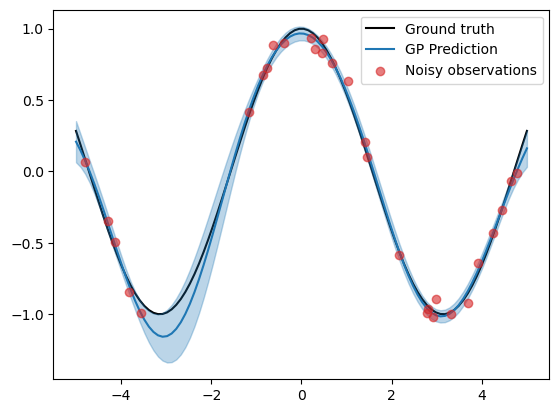

In [14]:
# Predict again
pred_dict = gpr.predict(X_grid[:,None])

# Extract mean, variance and standard deviation
f_mean = pred_dict['f*']
f_var = pred_dict['f*_var']
f_std = np.sqrt(f_var)

# Plot predictions
plt.plot(X_grid, f_truth, 'k', zorder=0, label='Ground truth')
plt.plot(X_grid, f_mean, color='C0', zorder=1, label='GP Prediction')
plt.fill_between(X_grid, f_mean-1.96*f_std, f_mean+1.96*f_std, color='C0', alpha=0.3)
plt.scatter(X, y, color='C3', alpha=0.6, zorder=2, label='Noisy observations')
plt.legend()

We see that the uncertainty bounds are now tighter around the ground truth after training, although the mean prediction is a little bit more off than before.

This is reflected in the metrics:

In [15]:
print(f"Mean squared error: {np.mean((f_truth - f_mean)**2):.4f}")
print(f"Mean log likelihood: {scipy.stats.norm.logpdf(f_truth, f_mean, f_std).mean():.4f}")

Mean squared error: 0.0037
Mean log likelihood: 1.8717
